In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('/mnt/nfs/user/danxu/python_nbs')
from HappyWorkFriends.InviteFriends import *
from fastai.plots import *

# MHC I型新生抗原质谱数据预测模型

## modeling & Training

In [3]:
from HappyWorkFriends.InviteFriends import *
from sklearn.metrics import confusion_matrix
#from fastai.plots import plot_confusion_matrix

import theano
import keras
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import Add, Dense, Dot, Flatten, Input, Lambda, RepeatVector, Dropout, BatchNormalization, Multiply

#assert np.__version__ == '1.12.1', 'Incorrect version of numpy installed.'
#assert keras.__version__ == '2.0.4', 'Incorrect version of keras installed.'
#assert theano.__version__ == '0.9.0', 'Incorrect version of theano installed.'

################################
# Model settings and constants #
################################

path = '/home/danxu/python_nbs/data/DL_NeoAntigen/ms_model'
len_peptide = 13  # the padded peptide length, i.e., the max peptide length
hla_per_sample = 6

AA_dict = {'A': 1,
           'C': 2,
           'D': 3,
           'E': 4,
           'F': 5,
           'G': 6,
           'H': 7,
           'I': 8,
           'K': 9,
           'L': 10,
           'M': 11,
           'N': 12,
           'P': 13,
           'Q': 14,
           'R': 15,
           'S': 16,
           'T': 17,
           'V': 18,
           'W': 19,
           'Y': 20,
           'Z': 0}  # 'Z' is a padding variable

len_AA_dict = len(AA_dict)
HLAs = !cut -f2 {path}/../sample_hlatypes
HLAs = np.unique(np.reshape([i.split(',') for i in HLAs], (-1,)))
HLAs = HLAs.tolist()
n_HLAs = len(HLAs) + 1  # 0 is for a blank allele (for homozygotes)

########################################
# Input data encoding helper functions #
########################################
def cut_pep(in_pep):
    pL = len(in_pep)
    if pL <= 11: return(in_pep)
    L = 11; start = np.random.randint(pL-L)
    return(in_pep[start:start+L])

def category_encode(data, categories):
    if isinstance(data, str):
        data = [data]
    if isinstance(data, np.ndarray):
        data = data.tolist()
    encoded = []
    for datum in data:
        if datum not in categories:
            #raise ValueError('Category not found!: %s' % datum)
            encoded.append(0)
        else:
            encoded.append(categories.index(datum) + 1)
    return encoded


def hla_encode(alleles, hla_per_sample=hla_per_sample, HLAs=HLAs):
    if isinstance(alleles, np.ndarray):
        alleles = alleles.tolist()
    type_check = [isinstance(sample, list) for sample in alleles]
    if any(type_check):
        assert all(type_check), \
            'Must provide either a list of alleles or a list of allele lists!'
    else:
        alleles = [alleles]
    onehots = []
    for sample in alleles:
        onehot = category_encode(sample, HLAs)
        onehot = [0] * (hla_per_sample - len(onehot)) + onehot
        onehots.append(onehot)
    return np.array(onehots)


def peptide_encode(peptides, maxlen=None, AA_dict=AA_dict):
    if isinstance(peptides, str):
        peptides = [peptides]
    num_peptides = len(peptides)
    if maxlen is None:
        maxlen = max(map(len, peptides))
    onehot = np.zeros((num_peptides, maxlen), dtype=np.uint8)
    for i, peptide in enumerate(peptides):
        if len(peptide) > maxlen:
            msg = 'Peptide %s has length %d > maxlen = %d.'
            raise ValueError(msg % (peptide, len(peptide), maxlen))
        o = list(map(lambda x: AA_dict[x], peptide))
        k = len(o)
        o = o[:k // 2] + [0] * (maxlen - k) + o[k // 2:]
        if len(o) != maxlen:
            msg = 'Peptide %s has length %d < maxlen = %d, but pad is "none".'
            raise ValueError(msg % (peptide, len(peptide), maxlen))
        onehot[i, :] = o
    return np.array(onehot)

In [4]:
####################
# Keras model code #
####################
o_nodes = n_HLAs - 1 # output nodes
#np.random.seed(1987)

peptide_in = Input(shape=(len_peptide,), dtype='uint8', name='peptide')
peptide_onehot = Lambda(lambda x: K.one_hot(x, len_AA_dict),
                        output_shape=(len_peptide, len_AA_dict, ),
                        name='peptide_onehot')(peptide_in)
#peptide_onehot = Dropout(0.2)(peptide_onehot)
peptide_flatten = Flatten(name='peptide_flatten')(peptide_onehot)
peptide_dense = Dense(256,
                      activation='relu',
                      name='peptide_dense')(peptide_flatten)
peptide_dense = BatchNormalization()(peptide_dense)
#peptide_dense = Dropout(0.5)(peptide_dense)
peptide_out = Dense(o_nodes,
                    activation='sigmoid',
                    name='peptide_out')(peptide_dense)
#peptide_out = BatchNormalization()(peptide_out)
#peptide_out = Lambda(lambda x: K.sigmoid(x), output_shape=(o_nodes, ))(peptide_out)

hla_in = Input(shape=(hla_per_sample,), dtype='uint16', name='hla_onehot')
hla_embed = Embedding(n_HLAs,
                      o_nodes,
                      input_length=hla_per_sample,
                      trainable=False,
                      weights=[np.eye(o_nodes+1)[:, 1:]],
                      name='hla_embed')(hla_in)
hla_out = Lambda(lambda x: K.sum(x, axis=1, keepdims=False),
                 output_shape=(o_nodes, ),
                 name='hla_out')(hla_embed)
'''hla_embed = Embedding(n_HLAs,
                    16,
                    input_length=hla_per_sample,
                    #weights=[np.zeros([n_HLAs,16])],
                    name='hla_embed')(hla_in)
hla_out = Flatten()(hla_embed)
hla_out = Dropout(0.3)(hla_out)
hla_out = Dense(o_nodes, activation='relu')(hla_out)'''
model_out = Dot(-1, name='hla_deconv')([peptide_out, hla_out])
#model_out = Multiply()([peptide_out, hla_out])
#model_out = Dense(1, activation='sigmoid', name='output')(model_out)

try:
    del model
except NameError:
    pass
model = Model(inputs=[peptide_in, hla_in], outputs=model_out)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
trn_file = f'{path}/all.pep'
df = pd.read_csv(trn_file, sep='\t', usecols=['ms_seq','HLA','label'])
#pep = df.ms_seq.values; hla = [i.split(',') for i in df.HLA]

model_inputs = {'peptide': peptide_encode(df.epitope.values, maxlen=len_peptide),
                'hla_onehot': hla_encode([i.split(',') for i in df.HLA])
                }
labels = df.presented.values

In [12]:
model.fit(model_inputs, labels, validation_split=0.2, batch_size=64, epochs=1)

Train on 5464756 samples, validate on 1366189 samples
Epoch 1/1
5464756/5464756 [==============================] - 273s 50us/step - loss: 0.3060 - acc: 0.9567 - val_loss: 0.1615 - val_acc: 0.9439


In [5]:
# lr e-4
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(model_inputs, labels, validation_split=0.1, batch_size=64, epochs=3)

Train on 5763805 samples, validate on 640423 samples
Epoch 1/3


/home/danxu/3.software/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


5763805/5763805 [==============================] - 322s 56us/step - loss: 0.0566 - acc: 0.9772 - val_loss: 0.0226 - val_acc: 0.9959
Epoch 2/3
5763805/5763805 [==============================] - 306s 53us/step - loss: 0.0533 - acc: 0.9787 - val_loss: 0.0251 - val_acc: 0.9951
Epoch 3/3
5763805/5763805 [==============================] - 323s 56us/step - loss: 0.0507 - acc: 0.9800 - val_loss: 0.0217 - val_acc: 0.9956


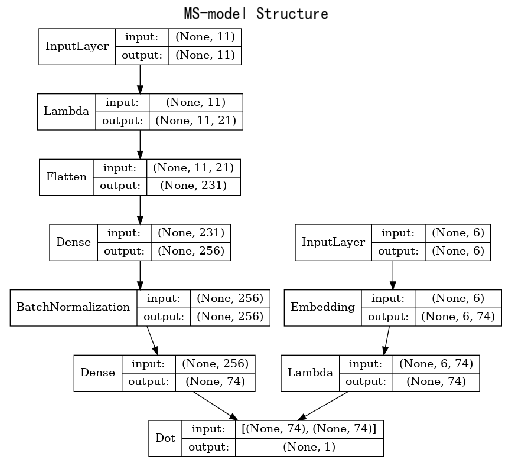

In [22]:
plots_from_files(['/mnt/nfs/user/danxu/python_nbs/data/DL_NeoAntigen/ms_model/models/model.png'], figsize=(10,8), titles=['MS-model Structure'])

## Validation use TESLA data

> 在TESLA 4例病人数据（去掉1例都没有阳性预测结果的样本）   
可以看出蓝色ms-model top结果中找到的阳性验证数优于仅用亲和力和公司已有模型

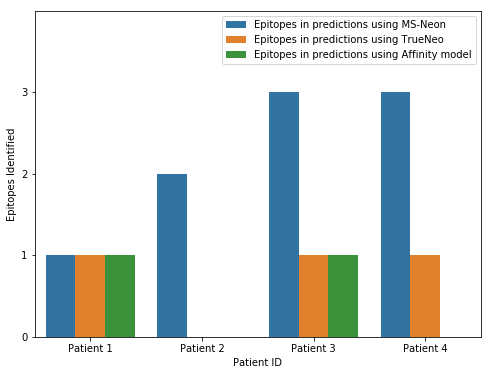

In [47]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data=df_plot, x='Patient ID', y='Epitopes Identified', hue='Model')
ax.legend(title=''); ax.set_ylim(0,4)
ax.set_yticks([0,1,2,3])
plt.show()

# PD-1 病理图片阴阳性区分

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from torchvision import models

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [5]:
PATH = "data/PD-L1.kaijie/"
sz=224
sz_y=224

In [58]:
o_path = f'{PATH}original'
train_path = f'{PATH}train'
val_path = f'{PATH}valid'
test_path = f'{PATH}test'

In [61]:
classes = os.listdir(f'{o_path}/')
for c in classes:
    os.makedirs(f'{train_path}/{c}', exist_ok=True)
    #os.makedirs(f'{test_path}/{c}', exist_ok=True)
    os.makedirs(f'{val_path}/{c}', exist_ok=True)
    path = f'{o_path}/{c}'
    files = np.array(os.listdir(f'{path}/'))
    idx = get_cv_idxs(len(files))
    #N = len(idx)//2
    #test_idx = idx[:N]
    #val_idx = idx[N:]
    val_files, trn_files = split_by_idx(idx, files)[0]; trn_files = ' '.join([f'{path}/{i}' for i in trn_files])
    val_files = ' '.join([f'{path}/{i}' for i in val_files])
    #test_files = split_by_idx(test_idx, files)[0][0]; test_files = ' '.join([f'{path}/{i}' for i in test_files])
    #val_files = split_by_idx(val_idx, files)[0][0]; val_files = ' '.join([f'{path}/{i}' for i in val_files])
    os.system(f'cp {trn_files} {train_path}/{c}/')
    #os.system(f'cp {val_files} {test_path}/{c}/')
    os.system(f'cp {val_files} {val_path}/{c}/')

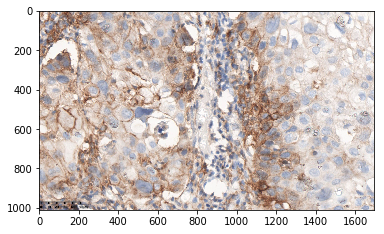

In [200]:
img = plt.imread(f'{PATH}valid/Positive/{files[3]}')
plt.imshow(img);

## Our first model: quick start

In [189]:
# Uncomment the below if you need to reset your precomputed activations
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [30]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz, sz_y=sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

  0%|          | 0/2 [00:00<?, ?it/s]

/mnt/nfs/user/danxu/python_nbs/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/mnt/nfs/user/danxu/python_nbs/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 2/2 [00:23<00:00, 13.69s/it]


epoch      trn_loss   val_loss   accuracy               
    0      1.009037   0.680187   0.538462  
    1      0.823549   0.594789   0.692308                



[0.5947886954297076, 0.6923076988576533]

In [212]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    fnames = [os.path.basename(data.val_ds.fnames[x]) for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, fnames=fnames, figsize=(16,8))

Correctly classified


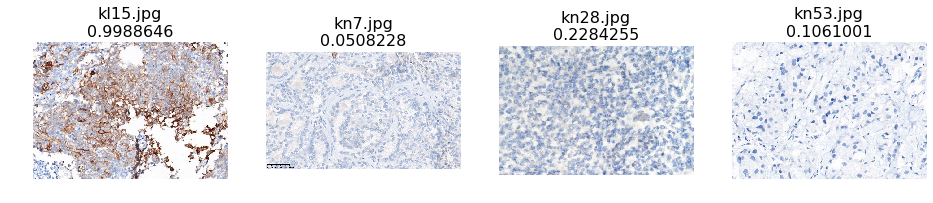

In [259]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


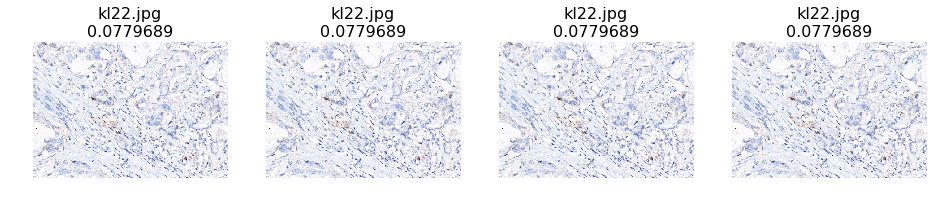

In [260]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [213]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct Negative


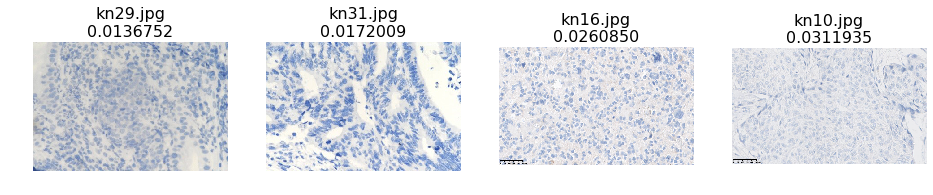

In [261]:
plot_val_with_title(most_by_correct(0, True), "Most correct Negative")

Most correct Positive


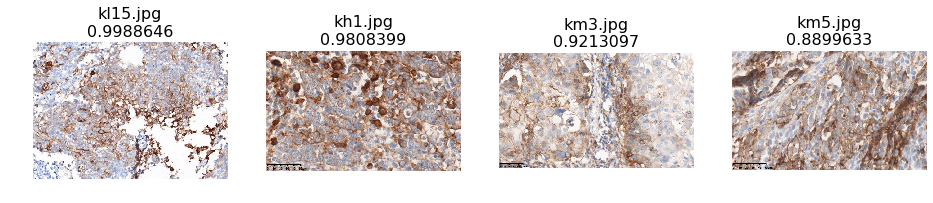

In [262]:
plot_val_with_title(most_by_correct(1, True), "Most correct Positive")

## Improving our model

### Data augmentation

In [21]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [22]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [23]:
ims = np.stack([get_augs() for i in range(6)])

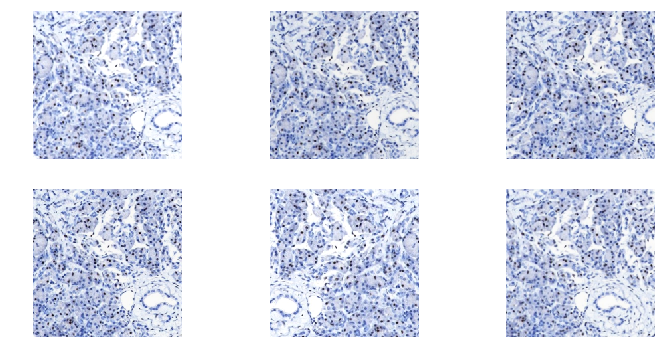

In [24]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [25]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

/mnt/nfs/user/danxu/python_nbs/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/mnt/nfs/user/danxu/python_nbs/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [26]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                
    0      0.945446   0.631819   0.659341  



[0.6318193235240139, 0.6593406606506516]

In [31]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [32]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.703518   0.556469   0.758242  
    1      0.599249   0.476256   0.846154                
    2      0.508108   0.402467   0.901099                



[0.402466947724531, 0.9010988965139284]

### Fine-tuning and differential learning rate annealing

In [245]:
learn.unfreeze()

In [246]:
lr=np.array([1e-4,1e-3,1e-2])

In [247]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      1.301023   0.746933   0.4375    
    1      0.926215   0.678763   0.5                     
    2      0.742005   0.653897   0.5625                  
    3      0.680822   0.571213   0.6875                  
    4      0.586486   0.468266   0.8125                  
    5      0.758894   0.370021   0.875                   
    6      0.700905   0.325851   0.875                   


[0.3258513808250427, 0.875]

## Analyzing results

### Confusion matrix 

In [268]:
#preds = np.argmax(probs, axis=1)
#probs = probs[:,1]
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
y = data.val_y

In [269]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[10  0]
 [ 1  5]]


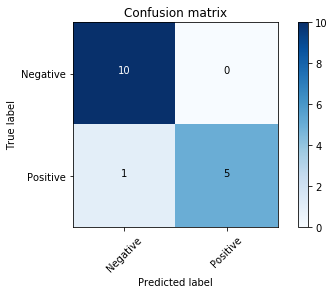

In [270]:
plot_confusion_matrix(cm, data.classes)

# 单样本TMB

## 流程示意

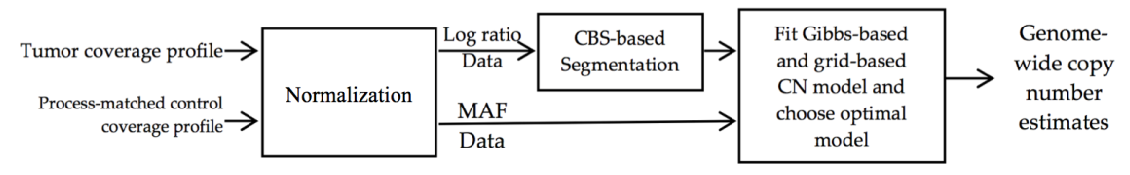

In [7]:
plots_from_files(['http://gitlab.yucebio.com/Dan.Xu/unmatched-tmb-detection/wikis/uploads/b2971b1bb0dc047dab7b69aab9d4e23a/image.png'], figsize=[20,4])

## 主脚本

In [25]:
# %load ../Project/unmatched_TMB/unmatched_tmb.py
#!/home/danxu/bin/mypython

import os, sys, re, fire, json
import numpy as np, pandas as pd
from glob import glob
from collections import defaultdict, OrderedDict

def get_coding_size(qualimm_json):
    with open(qualimm_json, 'r') as fo:
        jc = json.load(fo)
    cs = float(jc['Coding_size'].replace(',', '')) / 1000000
    return(cs)

def gen_mut_file_from_vardict_json(sample, mut_json, o_file):
    fo = open(o_file, 'w')
    fo.write(f'#sample\tmutation\tfrequency\tdepth\tpos\tstatus\tstrand\teffect\n')

    with open(mut_json, 'r') as f:
        mut_js = json.load(f)
    df = pd.DataFrame(mut_js['somatic_snvindel'])
    if not df.empty:
        df = df[df.impact.isin(['MODERATE','HIGH'])]
        df = df[~((pd.to_numeric(df['1000gp3_af']) > 0.005) | (pd.to_numeric(df['exac_af']) > 0.005))]
        df['Depth'] = df['variant_reads'] + df['reference_reads']
        for Chr,Pos,Gene,Effect,cDNA,depth,frequency in zip(df.chromosome, df.start, df.gene_symbol, df.impact, df.hgvsc, df.Depth, df.variant_freq):
            line = f'{sample}\t{Gene}:{cDNA}\t{frequency}\t{depth}\t{Chr}:{Pos}\tlikely\t+\t{Effect}\n'
            fo.write(line)
    fo.close()

class MissParameterError(Exception): pass

class unmatched_tmb_process():
    '''Find somatic mutation and calculate TMB of an unmatched tumor sample.'''
    def __init__(self, sample='SAMPLE', outdir='./', chip='YCone2.2', freq_thld=0.05):
        if chip == 'YCone2.2':
            self.purecn_script = '/home/danxu/3.software/PureCN/PureCN_v2.2.sh'
        elif chip == 'YCone1.3':
            self.purecn_script = '/home/danxu/3.software/PureCN/PureCN.sh'
        self.freq_thld = freq_thld  #突变频率阈值
        self.sample = sample
        self.purecn_dir, self.sgz_dir = f'{outdir}/purecn/{sample}', f'{outdir}/SGZ/{sample}'
        self._version = 'v1.0'

    def _read_vcfINFO_to_df(self, vcffile):
        arr = []
        with open(vcffile, 'r') as f:
            for l in f:
                if l[0] == '#': continue
                dic = {}
                l = l.strip().split('\t')
                flags = l[8].split(':'); values=l[9].split(':')
                dic['frequency'] = float(values[2].strip('%'))/100
                R, M = values[1].split(',')
                dic['depth'] = int(R) + int(M)
                dic['chr'] = l[0]; dic['pos'] = l[1]
                arr.append(dic)
        df = pd.DataFrame(arr)
        return(df)

    def run_purecn(self, bam_file, vcf_file):
        '''do purecn step to calculate tumor copy number and purity'''
        gatk = '/mnt/cfs/project/test_freshman/zhujiaqi/mutect2/script/gatk-4.1.2.0/gatk'
        dbsnp = '/mnt/nfs/database/hg19/gatk/dbsnp_138.hg19.vcf.gz'

        os.makedirs(self.purecn_dir, exist_ok=True)
        #db_vcf = f'{self.purecn_dir}/{self.sample}.snp.dbsnp.vcf'
        #os.system(f"sed -i 's/^##fileformat=VCFv4.3/##fileformat=VCFv4.2/' {vcf_file}")
        #os.system(f'{gatk} VariantAnnotator --variant {vcf_file} --dbsnp {dbsnp} -O {db_vcf}')
        os.system(f'{self.purecn_script} {bam_file} {self.sample} {vcf_file} {self.purecn_dir}')
        print('\npurecn Finished\n')

    def run_sgz(self, vardict_json):
        '''do sgz step to identify somatic'''
        #Begin
        os.makedirs(self.sgz_dir, exist_ok=True)
        purity_file = f'{self.purecn_dir}/{self.sample}.csv'
        purecn_file = f'{self.purecn_dir}/{self.sample}_loh.csv'
        header = 'CHR   segStart    segEnd  mafPred CN  segLR   segMAF  numMAtumorPred  numLRProbes numAFProbes purity  baseLevel'
        headers = header.split('\s+')

        # write sample.list
        with open(f'{self.sgz_dir}/sample.list', 'w') as fo:
            fo.write(f'sampleID\n{self.sample}\n')
        # write pathology purity result
        with open(f'{self.sgz_dir}/{self.sample}.pathology_purity.txt', 'w') as fo:
            fo.write(f'NA\n')

        # get purity and base_level
        df = pd.read_csv(purity_file)
        purity = df.iloc[0].Purity; ploidy = df.iloc[0].Ploidy
        base_level = round((purity*ploidy + 2*(1-purity)), 5)

        # read segmentation info
        df = pd.read_csv(purecn_file)

        df_for_sgz = pd.DataFrame(dict(CHR=df.chr, segStart=df.start.astype('int'), segEnd=df.end, mafPred=df['maf.expected'].round(6),
                                      CN=df.C, segLR=df['seg.mean'].round(6), segMAF=df['maf.observed'].round(6), numMAtumorPred=df.M,
                                      numLRProbes=df['num.mark'], numAFProbes=df['num.snps'], purity=purity, baseLevel=base_level))
        df_for_sgz.fillna('NA', inplace=True)
        df_for_sgz.to_csv(f'{self.sgz_dir}/{self.sample}.cna_calls.txt', index=None, sep='\t')

        # 生成sgz突变文件
        mut_file = f'{self.sgz_dir}/{self.sample}.mut_aggr.full.txt'
        gen_mut_file_from_vardict_json(self.sample, vardict_json, mut_file)

        # Run SGZ Script
        outline = '''
        export PYTHONPATH=$PYTHONPATH:"/mnt/nfs/software/lib/python2.7/site-packages/"
        /usr/bin/python2 /home/danxu/3.software/SGZ/run_SGZ.py \\
            -s %s/sample.list \\
            -f /home/danxu/3.software/SGZ/fmiSGZ.py \\
            -b /home/danxu/3.software/SGZ/basicSGZ.py \\
            -t %s \\
            -o %s
        ''' %(self.sgz_dir, self.sgz_dir, self.sgz_dir)
        os.system(outline)

    def calculate_unmatched_tmb(self, cs):
        '''calculate tmb based on purecn and sgz results'''
        purecn_file = f'{self.purecn_dir}/{self.sample}_variants.csv'
        # 读取purecn和sgz结果
        df_purecn = pd.read_csv(purecn_file)
        df_purecn['pos'] = [f'{c}:{p}' for c,p in zip(df_purecn.chr, df_purecn.start)]
        if os.path.exists(f'{self.sgz_dir}/{self.sample}.fmi.sgz.txt'):
            sgz_file =  f'{self.sgz_dir}/{self.sample}.fmi.sgz.txt'
        else:
            sgz_file =  f'{self.sgz_dir}/{self.sample}.basic.sgz.txt'
        df = pd.read_csv(sgz_file, sep='\t')

        # 去除在normal数据库中出现大于5次的突变结果
        df['pon.count'] = [df_purecn.loc[df_purecn.pos==pos, 'pon.count'].values[0] if pos in df_purecn.pos.values else 0 for pos in df.pos]
        df = df[df['pon.count'] <= 5]

        df = df[df.frequency>=self.freq_thld] #取大于阈值的突变结果
        # 算上高纯度cell line样本中>90% <100%的突变
        gt90 = df.frequency.between(.9, 1, inclusive=False)
        if gt90.sum() > 2:
            df.loc[gt90, 'germline/somatic'] = 'probable somatic'

        df = df[True ^ df['germline/somatic'].str.contains('germline|nocall_', regex=True)]
        df.to_csv(f'{self.sgz_dir}/muts_for_tmb.csv', sep='\t', index=None)

        unmatched_tmb = len(df)/cs

        # 结果输出
        with open(f'{self.sgz_dir}/{self.sample}.tmb.json', 'w') as fo:
            js = OrderedDict(Sample=self.sample, TMB=round(unmatched_tmb, 2))
            json.dump(js, fo, indent=2, ensure_ascii=False)

    def Pipeline(self, bam_file, vcf_file, vardict_json, qualimm_json=None, coding_size=None, do_purecn=True):
        '''Do the full process in one line.
           # vf=4G for YuceOne chip

           ES:
           --sample          # sample name
           --outdir          # output dir
           --bam_file        # bamfile of the tumor self.sample
           --vcf_file        # raw snp.vcf file produced by GATK
           --vardict_json    # vardict report json [TMB_P1.report.json]
           --qualimm_json    # qulimm json file for coding size info, set either --qualimm_json or --coding_size
           --coding_size     # tumor sample coding size from qc result(M)
           --chip            # YCone1.3|YCone2.2, default:YCone2.2
           --do_purecn=False # Optionally skip purecn step if you don't need to re-run it, default:True
        '''

        if qualimm_json == coding_size is None:
            raise MissParameterError('Either qualimm_json or coding_size should be defined.')
        if do_purecn==True: self.run_purecn(bam_file, vcf_file)
        self.run_sgz(vardict_json)
        if qualimm_json: coding_size = get_coding_size(qualimm_json)
        self.calculate_unmatched_tmb(coding_size)

    @property
    def VERSION(self):
        return(self._version)

if __name__ == '__main__': fire.Fire(unmatched_tmb_process)


"""
Copyright (c) 2020 D.X

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

## 单双样本TMB相关性分析

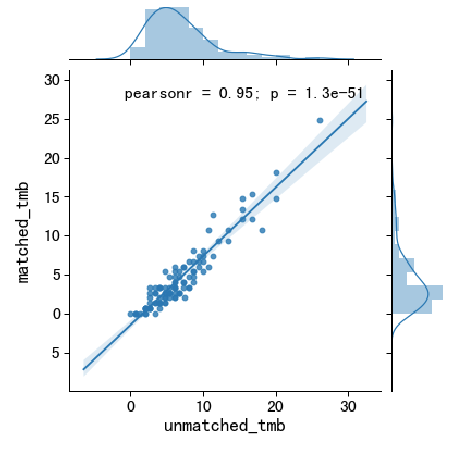

In [9]:
plots_from_files(['http://gitlab.yucebio.com/Dan.Xu/unmatched-tmb-detection/wikis/uploads/f53aed9e869e34a27af4825980f15bd7/image.png'], figsize=[8,8])

# 从突变到新生抗原的预测

## 主脚本

> 此脚本并不广适且不完整  
脚本用于从突变phasing.vcf到I, II型新生抗原的预测筛选

In [27]:
# %load ../Project/308-breast-cancer/Neoantigen_Miner.py
#!/usr/bin/env python

import sys, subprocess, fire
sys.path.append('/mnt/nfs/user/danxu/python_nbs')
from HappyWorkFriends.InviteFriends import *
from HappyWorkFriends.Olivia import save_writer, read_and_reset_mhcpan_result_DFcolumns_base, load_tcga_gene_rnaexp_dic
from Generate_Neopeptide import *

###########################################################################
###### Software
def status_message(msg):
    print(msg)
    sys.stdout.flush()

def run_cmd(cmd, msg=''):
    status_message(cmd)
    if ',' in msg:
        begin, finish = msg.split(',')
        status_message(begin)
    else:
        finish = msg
    try:
        subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT,)
    except subprocess.CalledProcessError as err:
        error_msg = 'Error happend!: {}\n{}'.format(err, err.output)
    else:
        error_msg = ''
    if not error_msg:
        status_message(finish)
        return True
    else:
        status_message(error_msg)
        return False

def vepanno(vcffile, ofile):
    vepsif = '/mnt/nfs/user/danxu/3.software/vep/vep.sif'
    vep = '/opt/vep/src/ensembl-vep/vep'
    filter_vep = '/opt/vep/src/ensembl-vep/filter_vep'
    CMD = f'''singularity exec -e -B /mnt {vepsif} {vep} \
-i {vcffile} -o STDOUT --no_stats \
--format vcf --vcf --canonical --symbol --terms SO --tsl --hgvs \
--fasta /mnt/nfs/database/hg19/reference/ucsc.hg19.fasta \
--cache --offline --cache_version 104 \
--dir_cache /mnt/afs/neo21c/neo/danxu/reference/vep/cache104 \
--dir_plugins /mnt/afs/neo21c/neo/danxu/reference/vep/Plugins \
--plugin Downstream --plugin Wildtype \
|singularity exec -e -B /mnt {vepsif} {filter_vep} \
-filter "CANONICAL is YES" --only_matched \
-o {ofile} --force_overwrite'''
    run_cmd(CMD, 'vep Annotation finished')

def filter_short_fasta(input_fasta, len_thld, prefix):
    arr_fasta = open(input_fasta, 'r').read().split('\n')
    name, ext = os.path.splitext(input_fasta)
    filtered_fasta = f'{name}.{prefix}{ext}'
    with open(filtered_fasta, 'w') as fo:
        for ix in range(0, len(arr_fasta)-1, 4):
            if len(arr_fasta[ix+1]) >= len_thld and len(arr_fasta[ix+3]) >= len_thld:
                fo.write('\n'.join(arr_fasta[ix:ix+4])); fo.write('\n')
    return(filtered_fasta)

def run_netMHC1_el(input_fasta, hla1, outfile):
    netMHC1 = '/mnt/nfs/user/danxu/3.software/netMHCpan-4.1/netMHCpan'
    filtered_fasta = filter_short_fasta(input_fasta, 8, 'MHC1')
    CMD = f'{netMHC1} -f {filtered_fasta} -a {hla1} -BA -l 8,9,10,11 -xls -xlsfile {outfile}'
    run_cmd(CMD, 'netMHC1_el fnished')

def run_netMHC2_el(input_fasta, hla2, outfile):
    netMHC2 = '/mnt/nfs/user/danxu/3.software/netMHCIIpan-4.0/netMHCIIpan'
    filtered_fasta = filter_short_fasta(input_fasta, 13, 'MHC2')
    for L in [13,14,15,16,17,18,19]:
        CMD = f'{netMHC2} -f {filtered_fasta} -a {hla2} -BA -length {L} -xls -xlsfile {outfile}.{L}'
        run_cmd(CMD)

###########################################################################
###### Neoantigen results annotation
def formatChr(Chr):
    Chr = str(Chr)
    if 'chr' in Chr:
        return(Chr.replace('chr', ''))
    else:
        return(Chr)

def clonal_info(clonal_file, dic_anno):
    df = pd.read_table(clonal_file)
    for n,i in df.iterrows():
        ChrPos = f"{formatChr(i['Chr'])}_{i['Start']}"
        dic_anno[ChrPos]['Clonal'] = 1 if i['ccf_binom'] >= 0.5 else 0

def rna_info(dic_anno, rna_mut_file=None, tcga_tpm_file=None):
    if rna_mut_file is not None:
        df = pd.read_table(rna_mut_file)
        dic_gene_rnaexp = {}
        for n,i in df.iterrows():
            dic_gene_rnaexp[i['Gene']] = i['TPM']
            dic_anno[f"{formatChr(i['Chr'])}_{i['Pos']}"]['RNAvaf'] = i['RNAvaf']
        return(dic_gene_rnaexp)
    elif rna_mut_file is None and tcga_tpm_file is not None:
        dic_gene_rnaexp = load_tcga_gene_rnaexp_dic(tcga_tpm_file)
        return(dic_gene_rnaexp)
    else:
        return({})

def index2mutinfo(tsv_file, vcf_file, clonal_file, rna_mut_file=None, tcga_tpm_file=None):
    '''
    read multiple files to generate a dictionary of mutation relative information,
    the dictionary will be used to annotate the neoantigen results.
    return dic_gene_rnaexp, dic_anno
    '''
    df = pd.read_table(tsv_file)
    dic_anno, dic_index2pos = defaultdict(dict), {}
    for n,i in df.iterrows():
        pos = i['start'] + 1 if i['variant_type'] == 'missense' else i['start']
        dic_index2pos[i['index']] = f"{formatChr(i['chromosome_name'])}_{pos}"
        dic_anno[f"{formatChr(i['chromosome_name'])}_{pos}"]['index'] = i['index']

    vcf_reader = vcf.Reader(filename=vcf_file)
    for record in vcf_reader:
        ChrPos = f"{formatChr(record.CHROM)}_{record.POS}"
        dic_anno[ChrPos]['DNAVAF'] = record.INFO['AF'][0]
        for csq in record.INFO['CSQ']:
            HGVSc = csq.split('|')[10]
            if HGVSc:
                dic_anno[ChrPos]['HGVSc'] = HGVSc
                break

    clonal_info(clonal_file, dic_anno)
    dic_gene_rnaexp = rna_info(dic_anno, rna_mut_file, tcga_tpm_file)

    Keys = ['Clonal','RNAvaf','DNAVAF','HGVSc']
    for ChrPos in dic_anno.keys():
        for Key in Keys:
            if not dic_anno[ChrPos].get(Key):
                dic_anno[ChrPos][Key] = np.nan
    return(dic_gene_rnaexp, dic_index2pos, dic_anno)

###########################################################################

###########################################################################
###### read and Generate results
def get_dic_id2mut(key_file):
    dic_id2mut = {}
    Keys, Values = [], []
    with open(key_file, 'r') as f:
        prvline, arr = None, []
        while True:
            if prvline is None:
                l = f.readline().strip()
            else:
                l = prvline; prvline = None
            if l == '': break
            if ':' in l:
                Keys.append(l.replace(':', ''))
                arr = []
            else:
                arr.append(re.sub(r'- ', '', l))
                for l in f:
                    l = l.strip()
                    if ':' in l:
                        prvline = l; Values.append(arr[0])
                        break
                    else:
                        arr.append(re.sub(r'- \.', '', l))
                else:
                    Values.append(arr[0])
    return(dict(zip(Keys, Values)))

def read_exp_tpm_to_dic(rna_file):
    df = pd.read_table(rna_file)
    return(dict(zip(df['HGNC'], df['TPM'])))

def var_hla1(hla1):
    if os.path.isfile(hla1):
        hla1 = open(hla1, 'r').read().strip()
    return(hla1.replace('*',''))

def var_hla2(hla2):
    if os.path.isfile(hla2):
        hla2 = open(hla2, 'r').read().strip()
    with open('/mnt/nfs/user/danxu/3.software/netMHCIIpan-4.0/data/allele.list', 'r') as f:
        hla2_available_list = f.read().split('\n')
    hla2 = hla2.replace('HLA-','').replace('*','_').replace(':','')
    hla2 = [i for i in hla2.split(',') if i in hla2_available_list]
    return(','.join(hla2))

def read_and_reset_mhcpan2_result_DFcolumns_base(file, start_cols=['Pos','Peptide','ID','Target'], rep_cols=['Score','Rank','Score_BA','nM','Rank_BA']):
    df = pd.read_table(file, header=[0,1]).reset_index()
    HLAs = open(file, 'r').readline().strip()
    ss = '\t' * len(rep_cols)
    HLAs = [i.replace('\t','') for i in HLAs.split(ss)]
    cols = [(i, "") for i in start_cols]
    for HLA in HLAs:
        for rep_col in rep_cols:
            cols.append((HLA, rep_col))
    cols.append(('Ave', '')); cols.append(('NB', ''))
    df.columns = pd.MultiIndex.from_tuples(cols)
    return(df)

def split_mutid(mutid):
    mwt, index = mutid.split('.', 1)
    arr = index.split('.')
    if len(arr) > 3:
        arr = ['.'.join(arr[:-2]) ,arr[-2], arr[-1]]
    return(arr + [mwt] + [index])

def Array2DF(arr, headers=None):
    if len(arr) == 0:
        if headers is not None:
            return(pd.DataFrame(columns=headers))
        return(None)
    else:
        return(pd.DataFrame(arr))

def generate_neoantigen_result_DF(dic_gene_rnaexp, dic_index2pos, dic_anno, neo_file, key_file, rna_file=None, tcga_tpm_file=None):
    df_mhc = read_and_reset_mhcpan_result_DFcolumns_base(neo_file)
    dic_id2mut = get_dic_id2mut(key_file)

    el_rank = [i for i in df_mhc.columns if i[1] == 'EL_Rank']
    ba_rank = [i for i in df_mhc.columns if i[1] == 'BA_Rank']
    arr4df = []

    IDs = df_mhc[('ID', '')].unique()[::2]
    for ID in IDs:
        df_wt = df_mhc.loc[df_mhc[('ID', '')] == ID]
        df_mt = df_mhc.loc[df_mhc[('ID', '')] == ID + 1]
        for (n1, wt), (n2, mt) in zip(df_wt.iterrows(), df_mt.iterrows()):
            for col1, col2 in zip(el_rank, ba_rank):
                if wt[('Peptide', '')] == mt[('Peptide', '')]:
                    # 排除延伸产生的相同序列
                    continue
                if mt[col1] < 0.5 and mt[col2] < 2:
                    tmp = {}
                    gene_transID, vtype, pchange, mwt, index = split_mutid(dic_id2mut[str(ID+1)])
                    gene, transID = gene_transID.split('_', 1)
                    ChrPos = dic_index2pos[index]
                    tmp['gene'], tmp['protein change'], tmp['HGVSc'] = gene, f'{transID}:p.{pchange}', dic_anno[ChrPos]['HGVSc']
                    tmp['variant type'], tmp['neopeptide'] = vtype, mt[('Peptide','')]
                    tmp['Allele'] = col1[0]
                    tmp['Affinity'] = 'SB' if mt[col2] < 0.5 else 'WB'
                    tmp['BA Rank(%)'], tmp['EL Rank(%)'] = mt[col2], mt[col1]
                    tmp['BA fold change'] = wt[col2] / (mt[col2] + 0.01)
                    tmp['rna_exp'] = dic_gene_rnaexp[gene] if dic_gene_rnaexp.get(gene) else 0
                    tmp['DNAVAF'], tmp['RNAvaf'] = dic_anno[ChrPos]['DNAVAF'], dic_anno[ChrPos]['RNAvaf']
                    tmp['Clonal'] = dic_anno[ChrPos]['Clonal']
                    arr4df.append(tmp)
    headers = ['gene','protein change','HGVSc','variant type','neopeptide','Allele','Affinity','BA Rank(%)','BA fold change','rna_exp',
               'DNAVAF','RNAvaf','Clonal']
    return(Array2DF(arr4df, headers))

def generate_neoantigen2_result_DF(dic_gene_rnaexp, dic_index2pos, dic_anno, neo_file, key_file, rna_file=None, tcga_tpm_file=None):
    neo_files = glob(f'{neo_file}.*')
    df_mhc = pd.DataFrame()
    for neo_file in neo_files:
        df_L = read_and_reset_mhcpan2_result_DFcolumns_base(neo_file)
        df_mhc = pd.concat([df_mhc, df_L])
    dic_id2mut = get_dic_id2mut(key_file)

    el_rank = [i for i in df_mhc.columns if i[1] == 'Rank']
    ba_rank = [i for i in df_mhc.columns if i[1] == 'Rank_BA']
    arr4df = []

    IDs = df_mhc[('ID', '')].unique()[::2]
    for ID in IDs:
        df_wt = df_mhc.loc[df_mhc[('ID', '')] == ID]
        df_mt = df_mhc.loc[df_mhc[('ID', '')] == ID + 1]
        for (n1, wt), (n2, mt) in zip(df_wt.iterrows(), df_mt.iterrows()):
            for col1, col2 in zip(el_rank, ba_rank):
                if wt[('Peptide', '')] == mt[('Peptide', '')]:
                    # 排除延伸产生的相同序列
                    continue
                if mt[col1] < 5:
                    tmp = {}
                    gene_transID, vtype, pchange, mwt, index = split_mutid(dic_id2mut[str(ID+1)])
                    gene, transID = gene_transID.split('_', 1)
                    ChrPos = dic_index2pos[index]
                    tmp['gene'], tmp['protein change'], tmp['HGVSc'] = gene, f'{transID}:p.{pchange}', dic_anno[ChrPos]['HGVSc']
                    tmp['variant type'], tmp['neopeptide'] = vtype, mt[('Peptide','')]
                    tmp['Allele'] = col1[0]
                    tmp['Affinity'] = 'SB' if mt[col2] < 0.5 else 'WB'
                    tmp['BA Rank(%)'], tmp['EL Rank(%)'] = mt[col2], mt[col1]
                    tmp['BA fold change'] = wt[col2] / (mt[col2] + 0.01)
                    tmp['rna_exp'] = dic_gene_rnaexp[gene] if dic_gene_rnaexp.get(gene) else 0
                    tmp['DNAVAF'], tmp['RNAvaf'] = dic_anno[ChrPos]['DNAVAF'], dic_anno[ChrPos]['RNAvaf']
                    tmp['Clonal'] = dic_anno[ChrPos]['Clonal']
                    arr4df.append(tmp)
    headers = ['gene','protein change','HGVSc','variant type','neopeptide','Allele','Affinity','BA Rank(%)','BA fold change','rna_exp',
               'DNAVAF','RNAvaf','Clonal']
    return(Array2DF(arr4df, headers))

def sort_and_filter_neoantigen(sample, df_mhc1, df_mhc2, odir):
    tpm_thld = 5
    if df_mhc1 is not None:
        df_mhc1.to_csv(f'{odir}/{sample}.MHC1.pre.tsv', sep='\t', index=None)
        df_mhc1 = df_mhc1[df_mhc1.rna_exp >= tpm_thld]
        df_mhc1.to_csv(f'{odir}/{sample}.MHC1.tsv', sep='\t', index=None)
    if df_mhc2 is not None:
        df_mhc2.to_csv(f'{odir}/{sample}.MHC2.pre.tsv', sep='\t', index=None)
        df_mhc2 = df_mhc2[df_mhc2.rna_exp >= tpm_thld]
        df_mhc2.to_csv(f'{odir}/{sample}.MHC2.tsv', sep='\t', index=None)
    if df_mhc1 is not None and df_mhc2 is not None:
        drop_cols = ['gene','variant type','rna_exp','HGVSc','DNAVAF','RNAvaf','Clonal']
        df_merge = pd.merge(df_mhc1.drop(drop_cols[:2], axis=1), df_mhc2.drop(drop_cols, axis=1), on='protein change')
        df_merge.to_csv(f'{odir}/{sample}.MHCboth.tsv', sep='\t', index=None)

###########################################################################

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

def subprocess_status(exit_code, Name):
    if exit_code:
        eprint(f'{Name} Failed')

def Pipeline(sample, input_vcf, hla1, hla2, odir, clonal_file, rnafile=None, tcga_tpm_file=None):
    '''Generate Neoantigen results from phasing.vcf

        ES:
        --sample [sample Name]
        --input_vcf [phasing.vcf file containing mutation]
        --hla1 [hla1 info file, or string]
        --hla2 [hla2 info file, or string]
        --odir [output directory]
        --clonal_file [clonal result file]
        --rnafile [optional, rna exp file, default=None]
        --tcga_tpm_file [optional, relative cancer TCGA exp file, default=TCGA-BRCA.TPM.json]
    '''
    os.makedirs(odir, exist_ok=True)
    vepvcf = f'{odir}/{sample}.vep.vcf'
    vepanno(input_vcf, vepvcf)
    temp_dir = generate_protein_fasta(vepvcf, odir) # Generate neoepitopes

    # relative annotation of mutaion dictionary
    dic_gene_rnaexp, dic_index2pos, dic_anno = index2mutinfo(f'{temp_dir}/tmp.tsv', vepvcf, clonal_file, rnafile, tcga_tpm_file)

    hla1, hla2 = var_hla1(hla1), var_hla2(hla2)
    run_netMHC1_el(f'{temp_dir}/tmp.fasta', hla1, f'{temp_dir}/MHC1.out.xls')
    df_mhc1 = generate_neoantigen_result_DF(dic_gene_rnaexp, dic_index2pos, dic_anno, f'{temp_dir}/MHC1.out.xls', f'{temp_dir}/tmp.fasta.key', rnafile, tcga_tpm_file)
    df_mhc2 = None
    if hla2:
        run_netMHC2_el(f'{temp_dir}/tmp.fasta', hla2, f'{temp_dir}/MHC2.out.xls')
        df_mhc2 = generate_neoantigen2_result_DF(dic_gene_rnaexp, dic_index2pos, dic_anno, f'{temp_dir}/MHC2.out.xls', f'{temp_dir}/tmp.fasta.key', rnafile, tcga_tpm_file)
    sort_and_filter_neoantigen(sample, df_mhc1, df_mhc2, odir)
    print('All Completed.')

if __name__ == '__main__': fire.Fire(Pipeline)


"""
Copyright (c) 2022 Dan.Thew

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""